In [100]:
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from GAE.graph_case_controller import GraphAutoEncoder
from GAE.graph_reconstructor import GraphReconstructor
from GAE.input_layer_constructor import InputLayerConstructor
from  GAE.graph_case_tools import Tools
import examples.example_graph_bell_version2 as gb
import math

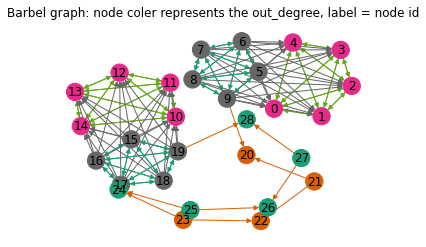

In [6]:
import networkx as nx
G =  nx.read_gpickle("/Users/tonpoppe/Downloads/graph.pickle")

plt.subplot(111)
# # pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
color = [G.out_degree(x) for x in range(G.number_of_nodes())]
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
options = {
'node_color': color,
'node_size': 300,
'edgelist':edges,
'edge_color':weights,
'width': 1,
'with_labels': True,
'pos': pos,
'edge_cmap': plt.cm.Dark2,
'cmap': plt.cm.Dark2
}
nx.draw(G, **options)
plt.title("Barbel graph: node coler represents the out_degree, label = node id")
plt.show()

In [12]:
gae = GraphAutoEncoder(
    G, support_size=[4, 4], dims=[3, 16, 16, 16], batch_size=3, hub0_feature_with_neighb_dim=None,
    useBN=True, verbose=True, seed=1, learning_rate=0.002, act=tf.nn.relu, encoder_labels=['attr1', 'attr2']
)

The following node labels are excluded []
The following node labels are included ['attr1', 'attr2']
The following edge labels are excluded []
The following edge labels are included ['weight']
train nodes [24, 9, 20, 17, 13, 0, 19, 25, 6, 12] ...
val nodes [27, 16, 11, 10, 22, 1, 5, 28, 7] ...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 72)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 72)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [85]:
in_sample = gae.sampler.data_feeder.in_sample
out_sample = gae.sampler.data_feeder.out_sample


In [112]:
def select_first_embeding(emb1, emb2):
    """Compares two positions embeddings and select the one with the shortest path to the root node.

    Args:
        emb1 (array<float>): position embeddding 1
        emb2 (array<float>): position embeddding 1

    Returns:
        array<float> : postion embeding that has the closest path to the root node.
    """
    
    # extract index of the last non zero value in the list
    max_ind1 = np.where(emb1)[0].max()
    max_ind2 = np.where(emb2)[0].max()
    
    # determine the value of the last not zero dimension in the list
    max_ind_value1 = emb1[max_ind1]
    max_ind_value2 = emb2[max_ind2]
    
    # closest to root node is the one with the lowest index of the last non zero value.
    # in case of a tie, then take the higest value of the last none zero value
    if [max_ind1, 1 - max_ind_value1] < [max_ind2, 1 - max_ind_value2]:
        return emb1
    else:
        return emb2
    
    
emb1 = [1, 0, 0.8, 0, 0]
emb2 = [1, 0, 0.6, 0, 0]
select_first_embeding(emb1, emb2)

[1, 0, 0.8, 0, 0]

In [115]:
def add_layers_to_pos_dic(id, in_sample, out_sample, pos_dic, prefix, hubs, current_hub):
    """Adds the position embedding of the nodes in the local neighborhood of the root node.
    This function is call recirsively in a depth first manner and initiated with the id of the root node
    

    Args:
        id (integer): id of the node for which the neighbors are added.
        in_sample (_type_): sampled incoming neighbors per node id
        out_sample (_type_): sampled outgoing neighbors per node id
        pos_dic (_type_): dictionary with the positional embedding for all nodes in the local neighborhood of the root node 
        prefix (_type_): first part of the position embedding that is fixed
        hubs (_type_): total number of hubs in the local neighborhood
        current_hub (_type_): current hub.
    """    
    # process the incoming sampled nodes
    sample = in_sample[id]
    in_lenght = (hubs - current_hub) * 2 + 1
    for i, nn in enumerate(sample):
        # update position embedding with the lowest value as this value has the shortest path to the root node
        # position encoding is prefix + 1 + 0 for remaining part of the vector
        this_position = prefix + [1 - i / sample.shape[0]] + [0] * in_lenght
        pos_emb =  select_first_embeding(pos_dic.get(nn, [1]*hubs), this_position)
        pos_dic[nn] = pos_emb
        if current_hub < hubs:  # sample the next hub
            current_hub = current_hub + 1
            add_layers_to_pos_dic(nn, in_sample, out_sample, pos_dic, pos_emb[: 2 * current_hub - 1], hubs, current_hub)
        
    # process the outcoming sampled nodes
    sample = out_sample[id]
    out_lenght = (hubs - current_hub) * 2
    for i, nn in enumerate(sample):
        # update position embedding with the lowest value as this value has the shortest path to the root node
        # position encoding is prefix + 1 + 0 for remaining part of the vector
        this_position = prefix + [0] + [1 - i / sample.shape[0]] + [0] * out_lenght
        pos_emb =  select_first_embeding(pos_dic.get(nn, [1]*hubs), this_position)
        pos_dic[nn] = pos_emb
        if current_hub < hubs:  # sample the next hub
            current_hub = current_hub + 1
            add_layers_to_pos_dic(nn, in_sample, out_sample, pos_dic, pos_emb[: 2 * current_hub - 1], hubs, current_hub)
            

id = 1
pos_dic = {}
current_hub = 1
hubs = 2
prefix = [1] + [0] * (hubs * 2)
add_layers_to_pos_dic(id, in_sample, out_sample, pos_dic, prefix, hubs, current_hub)

pos_dic

{5: [1, 1],
 6: [1, 1],
 7: [1, 1],
 8: [1, 1],
 9: [1, 1],
 0: [1, 1],
 1: [1, 1],
 2: [1, 1],
 3: [1, 1],
 4: [1, 1]}

In [101]:

            
         
def create_pos_dicts(G, in_sample, out_sample, hubs):    
    pos_dicts = {}  # dictionary to hold the dictonaries for all nodes

    for id in G.nodes():
    # instantiate dictionary for position embedding for this root node.
        pos_dic = {}
        current_hub = 1
        prefix = [1] + [0] * (hubs * 2)  # only the first dimension of the embedding is set to 1
        add_layers_to_pos_dic(id, in_sample, out_sample, pos_dic, prefix, hubs, current_hub)
    
        # overwrite the position embedding for the root 
        pos_dic[id] = [1] + [0] * (hubs * 2)
        pos_dic[G.number_of_nodes-1] = [0] * (hubs * 2 + 1)
        
    
    # add next incoming layer
    in_nodes = in_sample[id]
    add_next_layer(sample, pos_dic, prefix, in_lenght)
    for nn in in_nodes:
        #check if node already in dummy
        if nn not in pos_dic:
            # add node to dict if not 
            pos_dic[nn] = prefix + 10**length_inc
            
    # add next outgoing layer
    out_nodes = out_sample[id]
    for nn in out_nodes:
        #check if node already in dummy
        if nn not in pos_dic:
            # add node to dict if not 
            pos_dic[nn] = prefix + 10**length_out
    
hubs = 2 

TypeError: unsupported operand type(s) for -: 'method' and 'int'

In [106]:
y = [0, 0, 2, 3, 1, 0, 0, 3, 0]
np.where(y)[0].max()

7

In [58]:
next_nodes

<tf.Tensor: shape=(3, 4), dtype=int64, numpy=
array([[23, 25, 29, 29],
       [ 5,  6,  7,  8],
       [21,  9, 29, 29]])>

In [59]:
ones = tf.ones(
    next_nodes.shape,
    tf.dtypes.int64  
    
)

In [60]:
tf.stack([next_nodes,ones],0)

<tf.Tensor: shape=(2, 3, 4), dtype=int64, numpy=
array([[[23, 25, 29, 29],
        [ 5,  6,  7,  8],
        [21,  9, 29, 29]],

       [[ 1,  1,  1,  1],
        [ 1,  1,  1,  1],
        [ 1,  1,  1,  1]]])>

In [78]:
order = list(range(1,support+1))
order = tf.constant([order])
order

<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[1, 2, 3, 4]], dtype=int32)>

In [81]:
tf.tile(order, [next_nodes.shape[0],1])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]], dtype=int32)>

In [83]:
pos_emb = tf.constant([[[1, 0, 1, 0, 0]]])
tf.tile(pos_emb, [3,3,1])

<tf.Tensor: shape=(3, 3, 5), dtype=int32, numpy=
array([[[1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0]],

       [[1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0]],

       [[1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0]]], dtype=int32)>